# 3 - Stationarity and Seasonality
This script tests time series for stationarity and examines seasonality.  Several time series forecasting models will be applied to this dataset and these models often require a time series to be stationary.  The focus of this particular case is Day Ahead and Real Time Local Marginal Pricing of electricity.  

Stationarity implies that a time series does not have a trend or seasonal effects.  This is analyzed by considering rolling calculations of descriptive statistics like mean or standard deviation.  A stationary time series will show a range of rolling statistical values that do not change much over time. The stationary time series reverts to its mean, and the deviations have constant amplitude, while short-term movements always look the same in the statistical sense.

Copyright Matt Chmielewski

December 10, 2024

https://github.com/emskiphoto

## Load Python Dependencies

In [82]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import numpy as np

import statsmodels.tsa.api as tsa
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import probplot, moment
from scipy.signal import periodogram
from statsmodels.tsa.stattools import grangercausalitytests

import matplotlib.pyplot as plt
import seaborn as sns
import calendar
# load all parameters from custom config.py file
from config import *
# load all custom functions from util.py file
from utils import *

### Custom Functions

## Load Features Table

In [5]:
file_features_select

WindowsPath('C:/Users/user/OneDrive/python_envs/ERCOT_electricity_price_forecast/data/features_select.csv')

In [6]:
df_features = pd.read_csv(file_features_select, index_col=0)
df_features.head(3)

,Known Y/N,Solving For,Actual,Feature Type,Category,Region,color,min,mean,median,max,std,var,kurt,skew,0.1th_ptile,2.5th_ptile,5.0th_ptile,25.0th_ptile,50.0th_ptile,75.0th_ptile,95.0th_ptile,97.5th_ptile,99.9th_ptile,Distribution
HB_NORTH (DALMP),False,True,False,DayAhead Price,DALMP,north,"(0.7137254901960784, 0.7137254901960784, 0.847...",2.37,66.51,48.86,2100.11,89.43,7.997930e+03,155.64,9.95,3.12,13.85,18.71,32.72,48.86,69.79,158.06,241.01,1260.44,lognorm
WZ_Coast (RTLOAD),False,False,True,Demand,RTLOAD,coast,"(0.5796078431372549, 0.7701960784313725, 0.873...",8749.86,13568.04,12843.12,21081.94,2853.44,8.142114e+06,-0.37,0.75,8914.59,9531.52,9876.30,11461.70,12843.12,15336.65,19286.96,19924.83,20961.93,gamma
WZ_ERCOT (RTLOAD),False,False,True,Demand,RTLOAD,ercot,"(0.5231372549019608, 0.73919261822376, 0.86154...",31955.06,50359.64,47656.77,79827.91,11211.23,1.256916e+08,-0.38,0.72,32293.87,34240.73,35704.56,41711.21,47656.77,57233.28,72703.42,75262.05,79155.51,gamma


## Load Pricing Data
Use native and augmented out-of-forecast time-series features identified by PCA process in "2 - Descriptive Statistics & Data Augmentation"

In [7]:
file_ts_select

WindowsPath('C:/Users/user/OneDrive/python_envs/ERCOT_electricity_price_forecast/data/ts_select.csv')

### Create df with selected time series features

In [8]:
df = pd.read_csv(file_ts_select, index_col=0, parse_dates=['DATETIME'])
df.index.freq = 'H'
df.head(3)

,WZ_Coast (BIDCLOSE_LOAD_FORECAST),WZ_ERCOT (BIDCLOSE_LOAD_FORECAST),WZ_East (BIDCLOSE_LOAD_FORECAST),WZ_FarWest (BIDCLOSE_LOAD_FORECAST),WZ_North (BIDCLOSE_LOAD_FORECAST),WZ_NorthCentral (BIDCLOSE_LOAD_FORECAST),WZ_SouthCentral (BIDCLOSE_LOAD_FORECAST),WZ_Southern (BIDCLOSE_LOAD_FORECAST),WZ_West (BIDCLOSE_LOAD_FORECAST),ERCOT (TOTAL_RESOURCE_CAP_OUT),ERCOT (SOLAR_STPPF_BIDCLOSE),ERCOT (WIND_STWPF_BIDCLOSE),GR_COASTAL (WIND_STWPF_BIDCLOSE),GR_ERCOT (WIND_STWPF_BIDCLOSE),GR_NORTH (WIND_STWPF_BIDCLOSE),GR_PANHANDLE (WIND_STWPF_BIDCLOSE),GR_SOUTH (WIND_STWPF_BIDCLOSE),GR_WEST (WIND_STWPF_BIDCLOSE),HB_NORTH (DALMP),HB_NORTH (RTLMP)
DATETIME,,,,,,,,,,,,,,,,,,,,
2022-01-02 06:00:00+00:00,10113.9004,37541.4701,1359.5601,3642.8799,1077.0699,12146.0996,5249.2202,2709.0400,1243.7000,8207.0,0.0,23892.3,1341.8,23892.3,2039.8,3305.5,2347.2,14858.0,23.79,17.3775
2022-01-02 07:00:00+00:00,10234.0283,40474.6773,1330.0509,3899.4763,1146.5392,14139.5410,5399.4766,3002.6992,1322.8658,9272.0,0.0,21607.9,1205.8,21607.9,1950.6,2653.6,2448.5,13349.4,26.63,6.8825
2022-01-02 08:00:00+00:00,9835.0029,39272.0467,1333.0690,3830.4451,1132.9419,13786.4736,5152.9219,2845.2454,1355.9469,9272.0,0.0,21461.2,1336.7,21461.2,1949.6,2491.2,2626.3,13057.4,24.79,8.1275


#### Quality Check df

In [9]:
assert df.notnull().any().any()
assert not df.columns.has_duplicates
assert not df.index.has_duplicates

### Create target_series dictionary containing time series for each cols_target:
In this case, the time series are:
* da_lmp (Day Ahead)
* rt_lmp (Real-Time) time series <BR>

And the values in the time-series are:
* Location Marginal Pricing (LMP)

In [10]:
# da_lmp = df.loc[:, 'HB_NORTH (DALMP)'].dropna()
# rt_lmp = df.loc[:, 'HB_NORTH (RTLMP)'].dropna()


In [27]:
data_ = df[cols_target].dropna()
target_series = {col_ : df[col_] for col_ in cols_target}
target_units = 'LMP ($)'
# del data_
print(cols_target, target_units)

['HB_NORTH (DALMP)', 'HB_NORTH (RTLMP)'] LMP ($)


#### Visualize Target Time Series

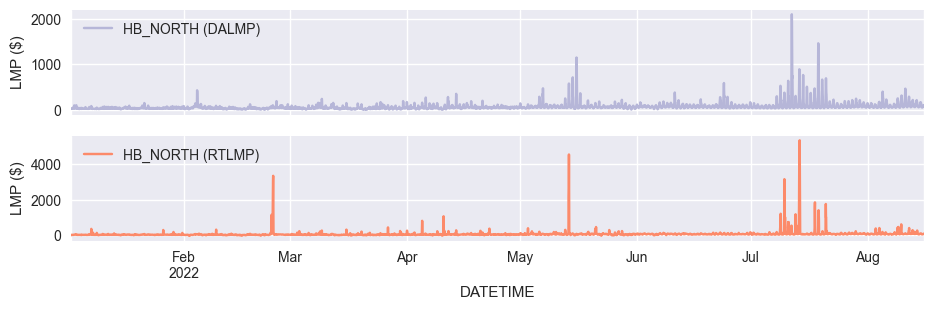

In [29]:
data_.plot(subplots=True, sharex=True, color=colors_features, ylabel=target_units, figsize=(11,3))
plt.show()

In [13]:
# # is this needed?  repeat of graph from notebook 2
# fig, ax = plt.subplots(figsize=(10,4), sharex=True)
# # calculate minimum and maximum value limits at 3 std
# x_min_std3, x_max_std3 = min_max_std_asymmetric(np.hstack([da_lmp, rt_lmp]),3)
# sns.ecdfplot(da_lmp.clip(x_min_std3, x_max_std3), color=colors_target, lw=4, ax=ax)
# sns.ecdfplot(rt_lmp.clip(x_min_std3, x_max_std3), color=colors_target, lw=4, ax=ax)
# plt.xlabel('Local Marginal Price')
# plt.legend(cols_target)
# plt.grid(axis='both')
# plt.title('Emprical Cumulative Distribution of Local Marginal Prices\n'
#          f'(clipped to {round(x_min_std3,3)} and {round(x_max_std3,3)})')
# plt.show()

In [14]:
# df.loc[:, cols_target].apply(lambda x: x.between(x_min_std3,x_max_std3)\
#                     .value_counts())

Observation:  
1. The majority of LMP values fall between -41 and 148.
2. Although prices above 148 are less than 5% of all occurrences, it is assumed they are significant due to their amplitude.  During model development choices may need to be made regarding the model's ability to perform better on:
    * high-frequency lower values
    * low-frequency high values

In [30]:
n_records_per_quantile = df.shape[0]*0.025

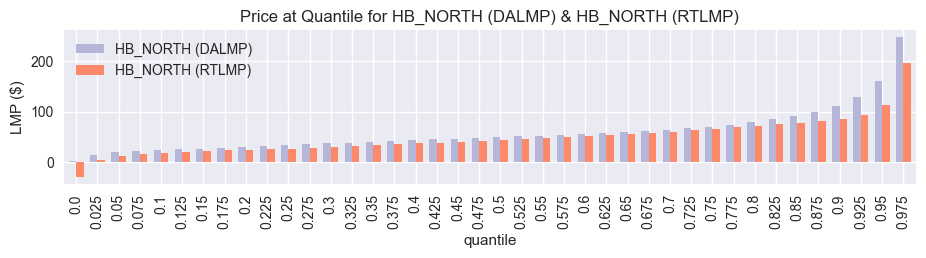

In [16]:
# fig, ax = plt.subplots(1,2, sharey=True, gridspec_kw={'wspace': 0.05})
# for ax_, col_ in cols_target
# df_quantiles['total_value'] = df_quantiles.rolling(2).mean().mul(n_records_per_quantile)
df[cols_target].quantile(np.round(np.arange(0,1,0.025),3)).plot.bar(figsize=(11,2), width=0.7,
    title=f'Price at Quantile for {" & ".join(cols_target)}', color=colors_features)
plt.ylabel(target_units)
plt.xlabel('quantile')
plt.show()

## Time-Series Decomposition

Time series data typically contains a mix of various patterns that can be decomposed into several components like trend, seasonality/cycles, and unsystematic noise (residuals). These components can be combined in an additive, linear model, in particular when fluctuations do not depend on the level of the series, or in a non-linear, multiplicative model. 

In [32]:
target_decompose = list(target_series.keys())[0]
x_decompose = target_series[target_decompose].dropna()
components = tsa.seasonal_decompose(x_decompose, model='additive')

#### Create df_ts_comps containing decomposed

In [33]:
df_ts_comps = (x_decompose.to_frame('Original')
      .assign(Trend=components.trend)
      .assign(Seasonality=components.seasonal)
      .assign(Residual=components.resid))

#### Visualize Time-Series components - whole year

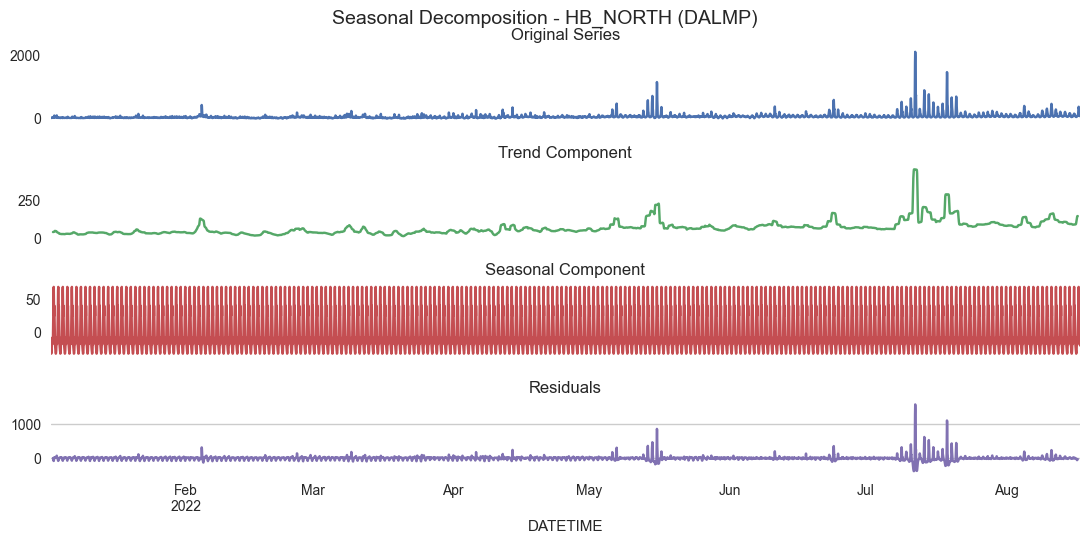

In [36]:
with sns.axes_style('white'):
    df_ts_comps.plot(subplots=True, figsize=(11, 5.5),
    title=['Original Series', 'Trend Component', 'Seasonal Component','Residuals'], legend=False)
    plt.suptitle(f'Seasonal Decomposition - {target_decompose}', fontsize=14)
    plt.grid(axis='y')
    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust(top=.91);

#### Identify months with lowest and highest Standard Deviation

In [37]:
month_min_std, month_max_std  = x_decompose.groupby(x_decompose.index.month).std()\
                                .agg([pd.Series.idxmin, pd.Series.idxmax])
month_min_std, month_max_std

(1, 7)

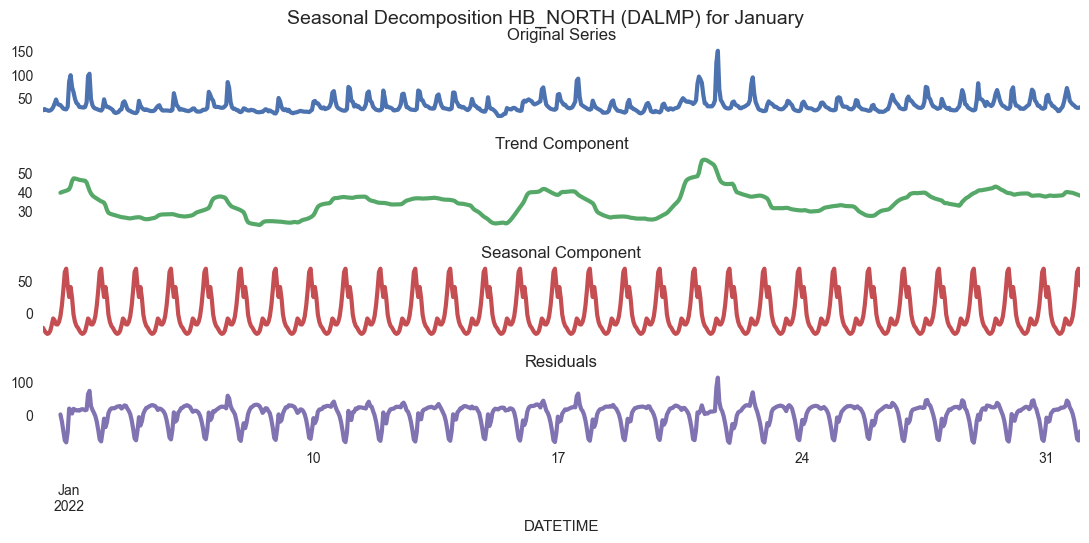

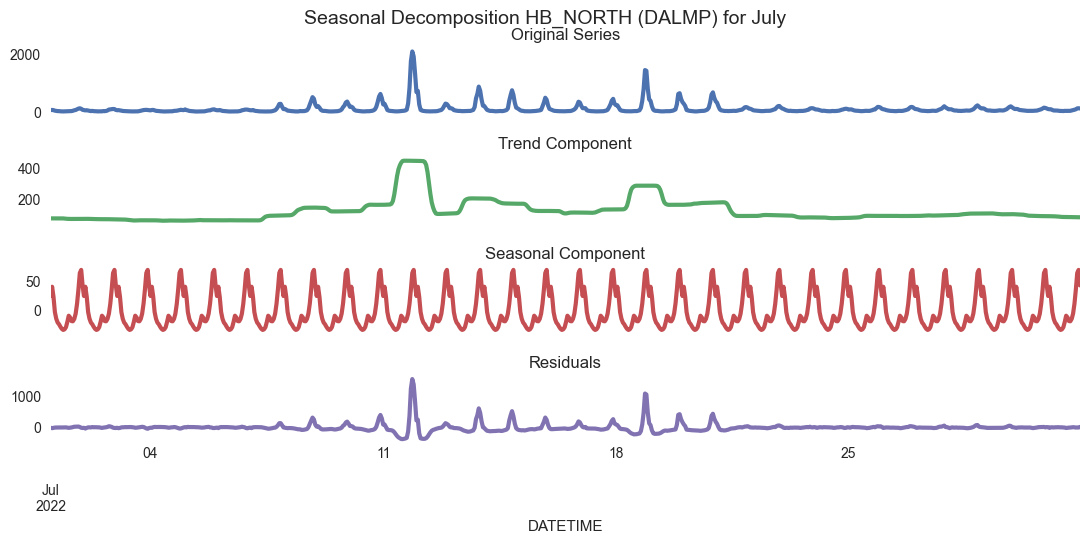

In [38]:
month_num = 6
for month_num in [month_min_std, month_max_std]:
    with sns.axes_style('white'):
    #    df_ts_compsplot(subplots=True, figsize=(14, 8),
        df_ts_comps.loc[df_ts_comps.index.month == month_num].plot(subplots=True, figsize=(11, 5.5), lw=3,
        title=['Original Series', 'Trend Component', 'Seasonal Component','Residuals'], legend=False)
        plt.suptitle(f'Seasonal Decomposition {cols_target[0]} for {calendar.month_name[month_num]}', fontsize=14)
        sns.despine()
        plt.tight_layout()
        plt.subplots_adjust(top=.91);
        plt.show()

In [39]:
ts_24 =df_ts_comps.pivot_table(index=df_ts_comps.index.hour, columns=df_ts_comps.index.day)\
            .rename_axis(['Type', 'Day'], axis=1, )
ts_24.head()

Type        Original                                                       \
Day               1          2         3         4          5          6    
DATETIME                                                                    
0          78.940000  69.060000  68.12250  79.30875   87.55000   78.69000   
1         102.105714  73.402857  89.07000  93.75875  102.92875  122.73125   
2          84.124286  74.892857  78.97250  78.03625   93.39375  107.89750   
3          57.111429  57.594286  60.58375  65.73875   69.52250   68.81500   
4          48.510000  47.448571  50.10875  57.09875   58.36250   50.82000   

Type                                                                       \
Day              7         8          9          10         11         12   
DATETIME                                                                    
0          99.73250  76.28625   99.15125   92.15000  127.27000  165.27000   
1         134.85375  97.20750  123.85250  103.69375  134.22875  187.49125   
2         108.90000  86.38000  104.61500   92.82625  110.36750  114.98125   
3          62.89875  65.11250   71.83250   64.94000   67.66625   70.09875   
4          52.76875  53.25750   58.53375   52.35625   53.46125   59.50000   

Type                                                                        \
Day             13         14         15         16         17          18   
DATETIME                                                                     
0         84.78000  114.51250  110.07375  135.30625  104.08250   88.221429   
1         97.77000  139.84250  112.31625  130.99375  112.43875  107.937143   
2         89.37000  122.78250   85.44500   85.66625  100.48875   79.224286   
3         63.95375   76.53125   59.68125   62.66875   61.39125   58.560000   
4         56.37625   58.43875   48.30750   52.09250   50.19250   47.210000   

Type                                                                \
Day               19          20          21         22         23   
DATETIME                                                             
0         120.102857   94.337143  109.100000  67.008571  76.965714   
1         133.874286  105.422857  121.854286  73.700000  84.272857   
2          96.392857   81.558571   97.827143  69.540000  82.375714   
3          63.095714   52.818571   66.214286  55.590000  64.487143   
4          51.537143   45.722857   49.741429  48.667143  51.441429   

Type                             ...      Trend                        \
Day               24         25  ...         7          8          9    
DATETIME                         ...                                    
0          88.530000  68.112857  ...  61.517552  61.703906  74.150104   
1         106.870000  93.922857  ...  61.947318  61.786719  74.384687   
2          95.084286  95.284286  ...  62.440833  61.933828  74.760391   
3          71.045714  65.717143  ...  62.707630  62.227708  74.700964   
4          57.105714  53.871429  ...  62.857135  62.567760  74.462187   

Type                                                                         \
Day              10         11          12         13         14         15   
DATETIME                                                                      
0         68.037109  80.335417  116.721250  66.385625  88.319870  80.236120   
1         67.659557  80.328281  116.904062  66.195807  88.262031  79.860391   
2         67.122812  80.188255  117.167187  65.971328  88.105260  79.508984   
3         66.906771  80.199974  117.323802  65.912865  87.932656  79.191250   
4         66.818958  80.395521  117.350677  65.976615  87.821198  78.889948   

Type                                                                        \
Day              16         17         18         19         20         21   
DATETIME                                                                     
0         80.804609  61.163929  61.209167  87.123363  60.522976  65.798125   
1         81.040547  61.263631  61.403244  87.0771

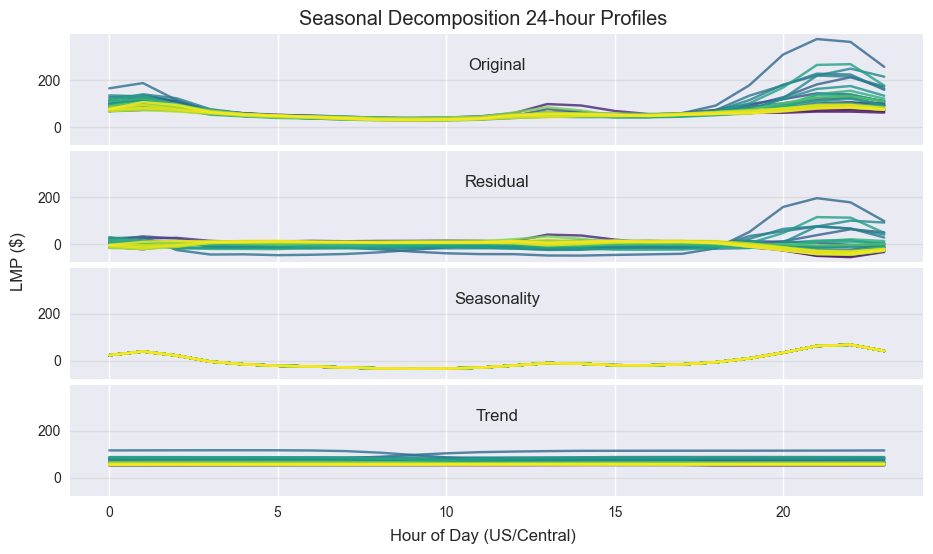

In [40]:
fig, ax = plt.subplots(nrows=len(ts_24.columns.levels[0]), ncols=1, sharex=True, sharey=True,
                       figsize=(11,6), gridspec_kw={'hspace': 0.05})
for ax_, col in zip(ax.flatten(), ts_24.columns.levels[0]):
    ts_24.loc[:, pd.IndexSlice[col]].plot(legend=None, colormap='viridis', ax=ax_, alpha=0.8, grid='y', xlabel='')
    ax_.set_title(col, y=0.6)
    ax_.grid(axis='y', color='grey', alpha=0.15)
#     ax_.legend()
# fig.legend()
fig.supxlabel(f'Hour of Day ({timezone})', y=0.03)
fig.supylabel(target_units, x=0.07)
fig.suptitle('Seasonal Decomposition 24-hour Profiles', y=0.92)
plt.show()

In [41]:
ts_24_12 = df_ts_comps.pivot_table(index=df_ts_comps.index.hour,
               columns=[df_ts_comps.index.month,df_ts_comps.index.day])\
            .rename_axis(['Type', 'Month', 'Day'], axis=1, )
ts_24_12.head()

Type     Original                                                          \
Month           1                                                           
Day            2      3      4      5      6      7      8      9      10   
DATETIME                                                                    
0             NaN  84.63  47.05  43.98  60.02  62.93  28.09  49.99  42.04   
1             NaN  98.07  35.37  33.98  47.07  56.55  27.14  43.30  43.73   
2             NaN  72.65  30.99  29.14  34.21  48.47  24.55  31.00  38.81   
3             NaN  62.24  30.81  26.03  31.01  44.26  23.56  25.40  38.59   
4             NaN  48.31  29.05  24.53  25.08  31.85  23.35  24.14  34.44   

Type                                                                     \
Month                                                                     
Day          11     12     13     14     15     16     17     18     19   
DATETIME                                                                  
0         73.35  65.64  65.74  61.45  51.36  41.42  57.14  44.26  39.17   
1         70.24  50.22  63.51  61.30  31.08  44.41  58.36  36.25  45.91   
2         44.01  30.71  46.09  43.56  27.06  42.24  45.00  29.92  30.20   
3         41.93  32.00  45.16  38.86  26.68  45.20  40.31  28.10  29.78   
4         31.86  29.71  37.91  32.00  24.00  46.98  35.71  26.00  26.23   

Type                                                       ...      Trend  \
Month                                                      ...          7   
Day          20     21     22     23     24     25     26  ...         23   
DATETIME                                                   ...              
0         35.76  80.00  40.72  35.78  38.98  49.03  33.55  ...  93.474792   
1         38.03  95.17  42.53  42.74  42.16  51.51  35.27  ...  93.268750   
2         30.28  89.75  36.03  38.78  36.00  50.00  26.38  ...  93.022083   
3         26.78  82.07  33.98  37.91  30.09  38.48  25.60  ...  92.816042   
4         24.65  56.58  32.67  34.97  28.44  32.02  22.62  ...  92.578542   

Type                                                                         \
Month                                                                         
Day              24         25         26         27         28          29   
DATETIME                                                                      
0         79.091667  76.261667  89.081458  89.079167  93.803125  105.125625   
1         79.038333  76.524375  89.022500  89.263542  94.052500  105.321458   
2         78.916250  76.796042  88.946458  89.475208  94.369583  105.623958   
3         78.772917  77.000208  88.931875  89.546250  94.700417  105.874375   
4         78.632292  77.285833  88.965000  89.517292  94.968333  105.990833   

Type                                                                         \
Month                                    8                                    
Day               30         31         1          2          3          4    
DATETIME                                                                      
0         100.183333  87.254792  80.215417  82.994792  72.968542  86.285833   
1          99.589167  87.217708  80.328958  82.947500  72.664167  86.675833   
2          98.952708  87.064792  80.498750  82.777083  72.476458  86.885208   
3          98.529583  86.872708  80.598958  82.530833  72.561875  86.913750   
4          98.226250  86.600833  80.731458  82.200625  72.711042  87.190000   

Type                                                                           \
Month                                                                           
Day               5          6          7          8           9           10   
DATETIME                                                                        
0         138.059375  99.980208  72.348333  75.559583  110.126875  124.512917   
1         138.117083  99.802917  72.185417  75.789167  110.317083  124.828750   
2         138.427708  99.6

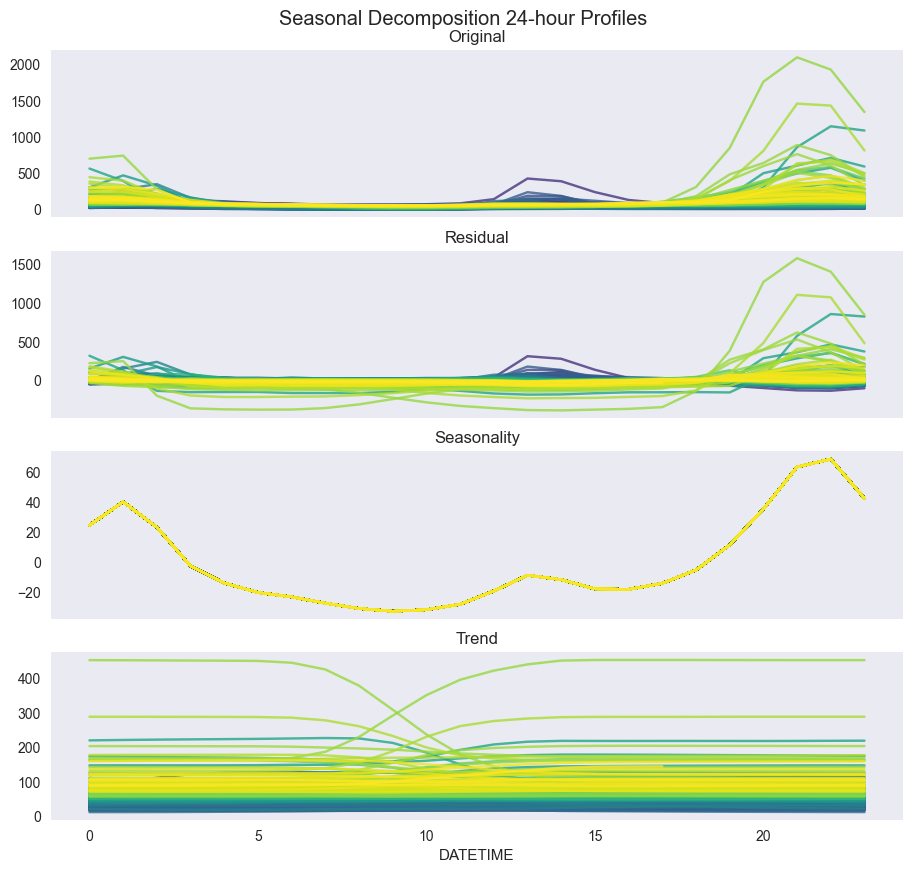

In [42]:
fig, ax = plt.subplots(nrows=len(ts_24_12.columns.levels[0]), ncols=1, sharex=True, figsize=(11,10))
for ax_, col in zip(ax.flatten(), ts_24_12.columns.levels[0]):
        ts_24_12.loc[:, pd.IndexSlice[col]].plot(legend=None, colormap='viridis', ax=ax_, alpha=0.8)
        ax_.set_title(col)
        ax_.grid(axis='both')
        fig.suptitle('Seasonal Decomposition 24-hour Profiles', y=0.92)

## Time Series Stationarity

The statistical properties, such as the mean, variance, or autocorrelation, of a stationary time series are independent of 
the period, that is, they don't change over time. Hence, _stationarity_ implies that a time series does not have a trend or seasonal effects and that descriptive statistics, such as the mean or the standard deviation, when computed for different rolling windows, are constant or do not change much over time. The series should revert to its mean, and the deviations have constant amplitude, while short-term movements always look the same.  In many cases, de-trending is not sufficient to make the series stationary.

__Process:__<BR>
To satisfy the stationarity assumption of linear time series models the original time series must be transformed over  several steps. 

* __Log Transformation__ -  to convert an _exponential_ growth pattern into a linear trend and stabilize the variance.
* __Differencing__ -  transform the original data into a series of period-to-period and/or season-to-season differences (use the result of subtracting neighboring data points or values at seasonal lags from each other). When differencing is applied to a log-transformed series, the results represent instantaneous growth rates or returns. 

### Log Transformation

Double check for zero values.  If present, infinite values will need to be resolved in log transformation.

In [43]:
has_zero = any((x == 0).any() for x in target_series.values())
has_zero

True

#### Create target_series_log as a log transformation of the source target series

In [44]:
# calculate log transformation
target_series_log = {k_ : np.log(v_) for k_, v_ in target_series.items()}

c:\users\user\onedrive\python_envs\ercot_electricity_price_forecast\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\users\user\onedrive\python_envs\ercot_electricity_price_forecast\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


#### Visualize Log Transformation of 400 highest values

In [48]:
pct_highest = 0.1
n_records_ = min((x_.shape[0] for x_ in target_series_log.values()))
n_highest = int(n_records_ * pct_highest)
n_highest

549

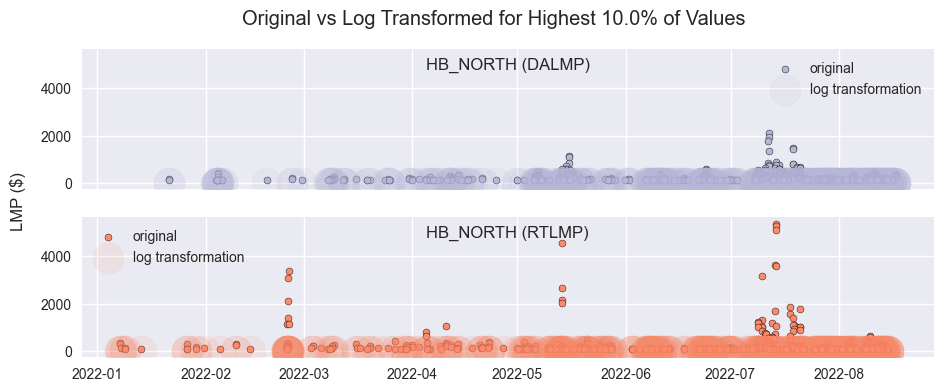

In [49]:
fig, ax = plt.subplots(target_series_log.__len__(), 1, sharey=True, sharex=True, figsize=(11,4))
for ax_, (target_, x_) in zip(ax.flatten(), target_series.items()):
    df_ = x_.to_frame().reset_index().nlargest(n_highest, target_)
    ax_.scatter(df_['DATETIME'], df_[target_], color=colors_target[target_], s=25,
                edgecolors='black', label='original')
    x_log_ = target_series_log[target_]
    df_log_ = x_log_.to_frame().reset_index().nlargest(n_highest, target_)
    ax_.scatter(df_log_['DATETIME'], df_log_[target_], color=colors_target[target_],
                s=500, label='log transformation', alpha=0.11)
    ax_.set_title(target_, y=0.8)
    ax_.legend()
fig.suptitle(f'Original vs Log Transformed for Highest {pct_highest*100}% of Values')
fig.supylabel(target_units, x=0.06)
plt.show()

#### Resolve inf and NaN values

In [50]:
for target_, x_ in target_series_log.items():
    display(x_.agg(['min', 'median', 'max']))
    x_new_ = clip_inf_values_to_quantile(x_)
    display(x_new_.agg(['min', 'median', 'max']))
    assert not any(np.isinf(x_new_.values))
    target_series_log[target_] = x_new_

min       0.862890
median    3.895182
max       7.649745
Name: HB_NORTH (DALMP), dtype: float64

min       0.862890
median    3.895182
max       7.649745
Name: HB_NORTH (DALMP), dtype: float64

min           -inf
median    3.787876
max       8.587810
Name: HB_NORTH (RTLMP), dtype: float64

min      -0.988912
median    3.787876
max       8.160791
Name: HB_NORTH (RTLMP), dtype: float64

### Differencing

In many cases, de-trending is not sufficient to make the series stationary. Instead, we need to transform the original data into a series of period-to-period and/or season-to-season differences. In other words, we use the result of subtracting neighboring data points or values at seasonal lags from each other. Note that when such differencing is applied to a log-transformed series, the results represent instantaneous growth rates or returns in a financial context. 

If a univariate series becomes stationary after differencing d times, it is said to be integrated of the order of d, or simply integrated if d=1. This behavior is due to so-called unit roots.

Differencing of log series produces instantaneous returns.

In [51]:
target_series_log_diff = {}
for target_, x_ in target_series_log.items():
    display(x_.agg(['min', 'median', 'max']))
    x_new_ = clip_inf_values_to_quantile(x_.diff().dropna())
    display(x_new_.agg(['min', 'median', 'max']))
    assert not any(np.isinf(x_new_.values))
    target_series_log_diff[target_] = x_new_

min       0.862890
median    3.895182
max       7.649745
Name: HB_NORTH (DALMP), dtype: float64

min      -1.245399
median   -0.010359
max       1.374852
Name: HB_NORTH (DALMP), dtype: float64

min      -0.988912
median    3.787876
max       8.160791
Name: HB_NORTH (RTLMP), dtype: float64

min      -3.519827
median   -0.004123
max       4.010068
Name: HB_NORTH (RTLMP), dtype: float64

In [52]:
transforms = ['original', 'log', 'log difference']
transforms_targets_series = dict(zip(transforms, [target_series, target_series_log, target_series_log_diff]))

In [53]:
transforms_targets_series['original']['HB_NORTH (DALMP)']

DATETIME
2022-01-02 06:00:00+00:00    23.79
2022-01-02 07:00:00+00:00    26.63
2022-01-02 08:00:00+00:00    24.79
2022-01-02 09:00:00+00:00    23.85
2022-01-02 10:00:00+00:00    22.81
                             ...  
2022-08-19 01:00:00+00:00      NaN
2022-08-19 02:00:00+00:00      NaN
2022-08-19 03:00:00+00:00      NaN
2022-08-19 04:00:00+00:00      NaN
2022-08-19 05:00:00+00:00      NaN
Freq: H, Name: HB_NORTH (DALMP), Length: 5496, dtype: float64

#### Visualize Transformation of Target Time Series to a Stationary Condition
The Augmented Dickey-Fuller (ADF) p-value allows us to reject the hypothesis of unit-root non-stationarity after all transformations.

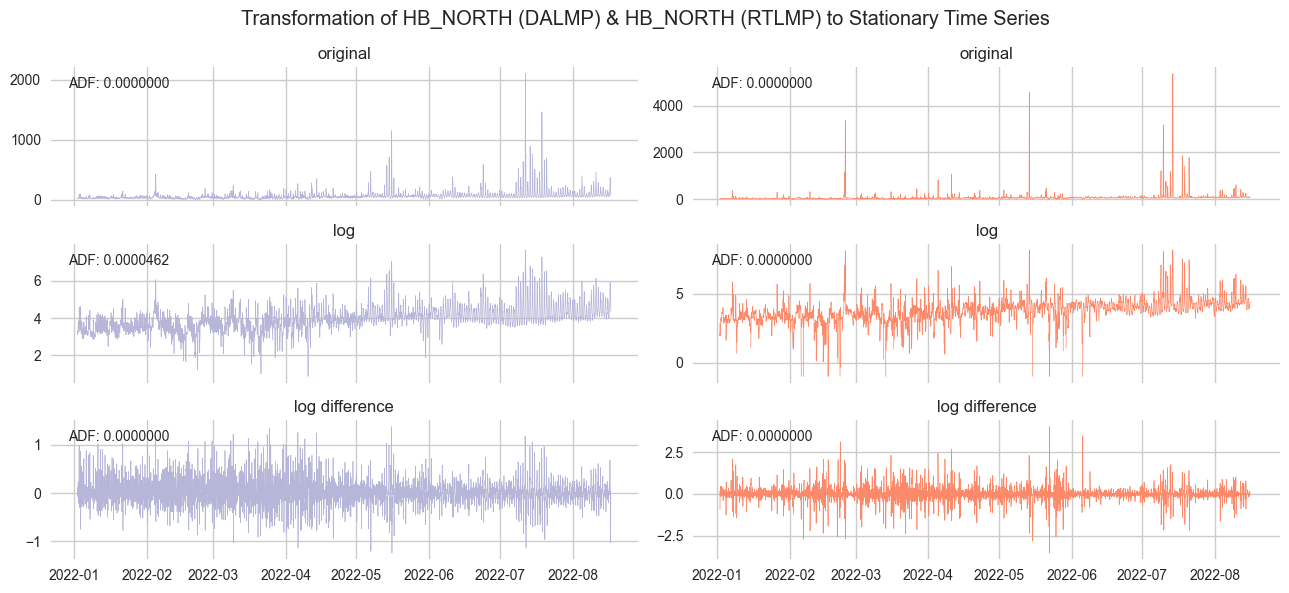

In [54]:
with sns.axes_style('white'):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(13, 6), sharex=True)
    for ax_col_, target_ in zip(range(axes.shape[1]), target_series.keys()):
        for ax_row_, (transform_, x_dict_) in zip(range(axes.shape[0]), transforms_targets_series.items()):
            ax_ = axes[ax_row_, ax_col_]
            x_ = x_dict_[target_]
            ax_.plot(x_, color=colors_target[target_], lw=0.5)
            ax_.set_title(transform_)
            ax_.grid(axis='both')
            ax_.text(x=.03,y=.85,s=f'ADF: {tsa.adfuller(x_.dropna())[1]:.7f}', transform=ax_.transAxes)
    fig.suptitle(f'Transformation of {" & ".join(target_series.keys())} to Stationary Time Series', y=0.98)
    fig.tight_layout()
    plt.show()

## Correlogram

Autocorrelation (also called serial correlation) adapts the concept of correlation to the time series context: just as the correlation coefficient measures the strength of a linear relationship between two variables, the autocorrelation coefficient, $\rho_k$, measures the extent of a linear relationship between time series values separated by a given lag, $k$.

A correlogram is a plot of the Auto-Correlation Function (ACF) or Partial Auto-Correlation Function (PACF) for sequential lags, k=0,1,...,n. It allows inspection of the correlation structure across different lags. The main usage of correlograms is to detect any autocorrelation after the removal of the effects of deterministic trend or seasonality.

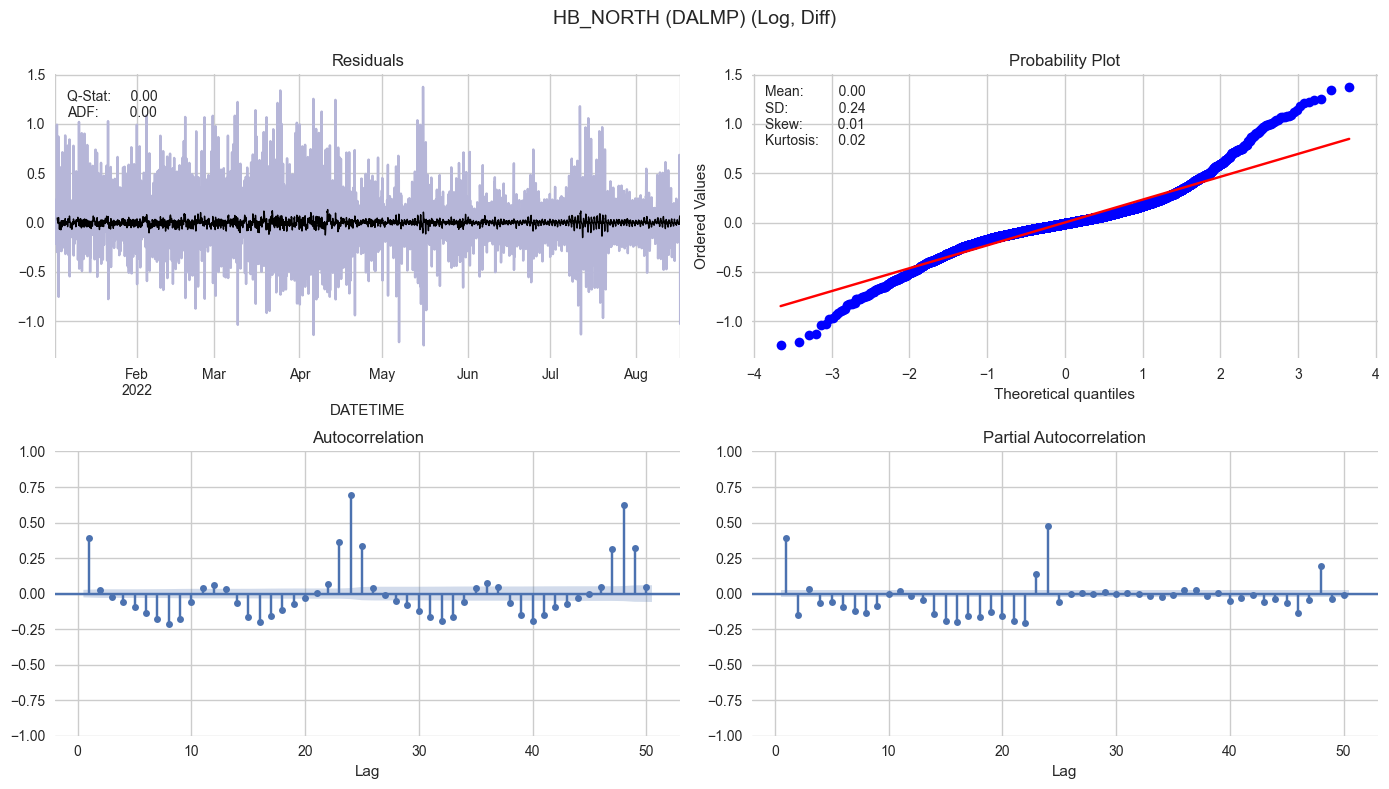

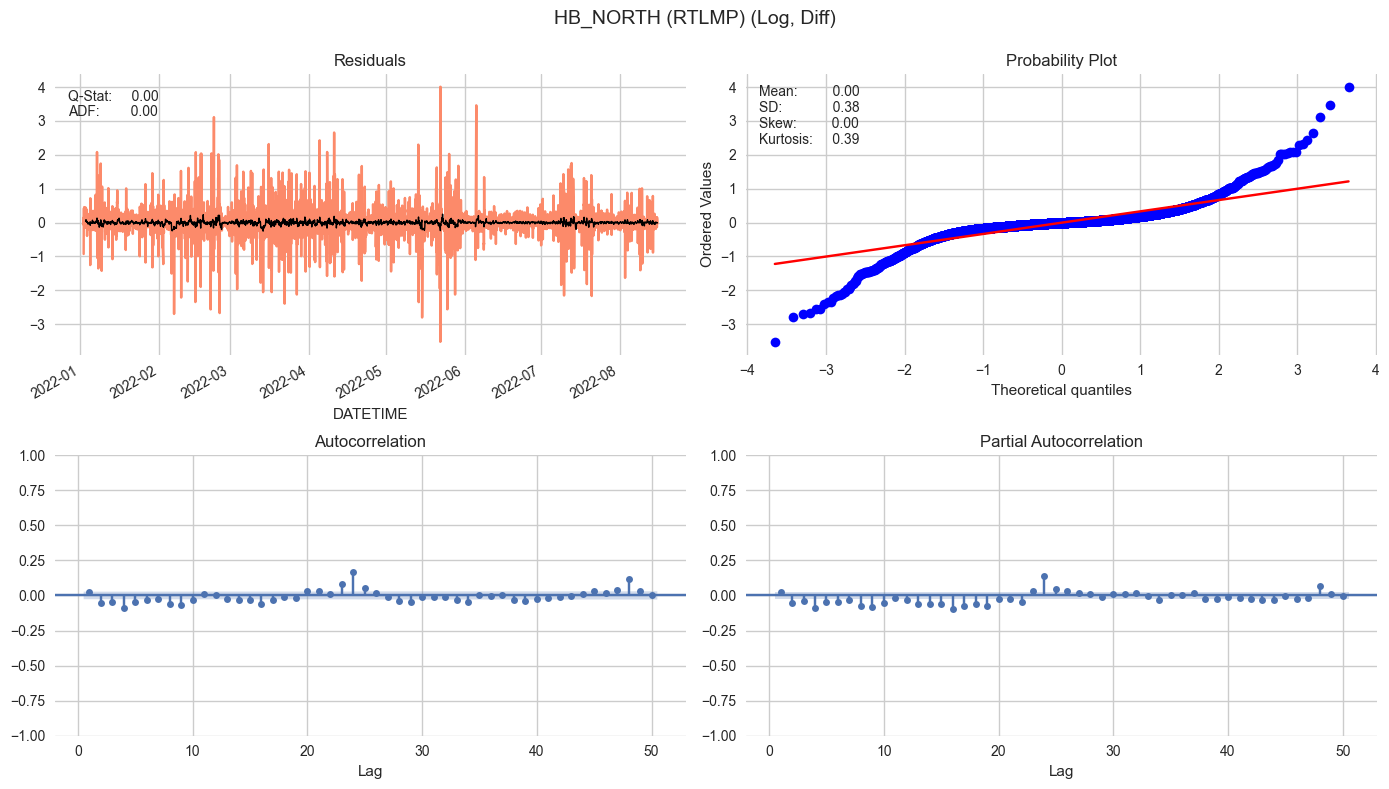

In [56]:
for target_, x_ in target_series_log_diff.items():
    plot_correlogram(x_, lags=50, title=f'{target_} (Log, Diff)', color=colors_target[target_])

#### Visualize Progression of Achieving Stationarity

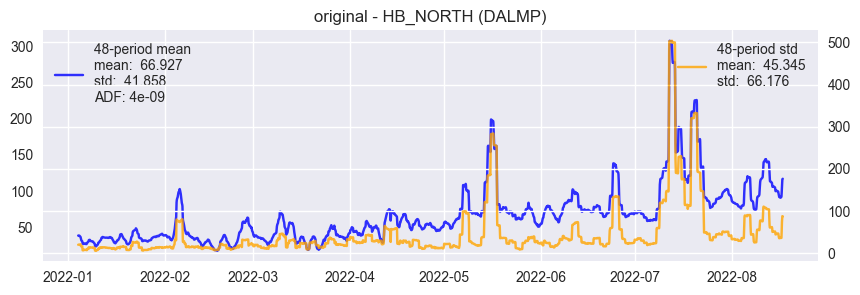

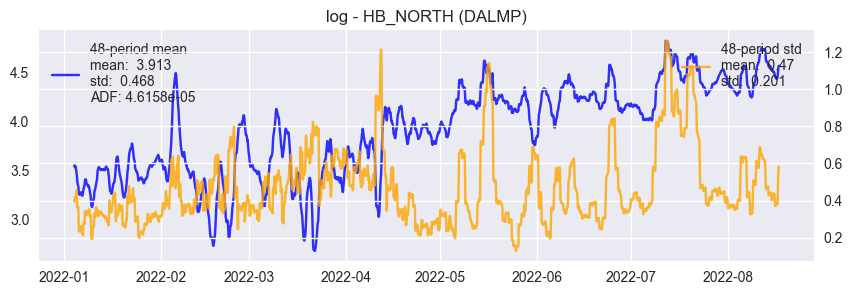

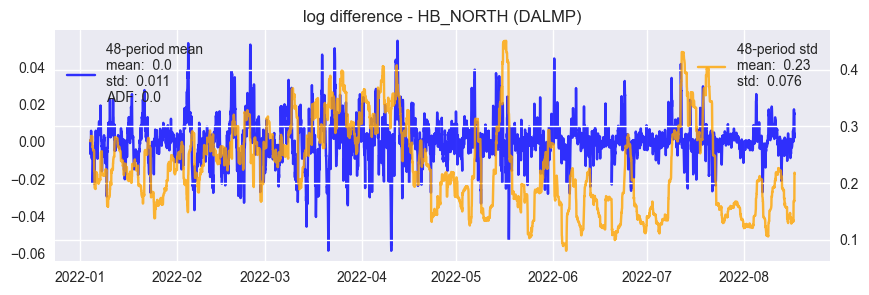

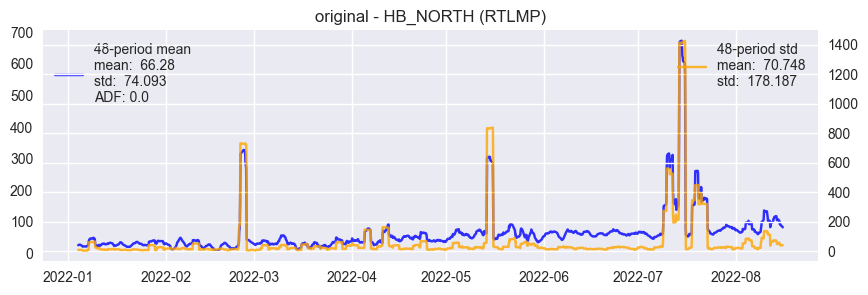

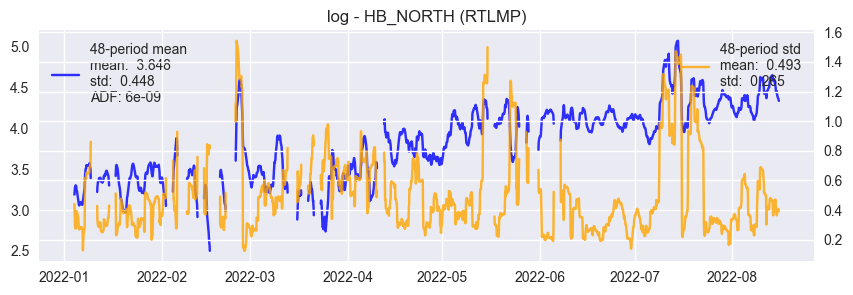

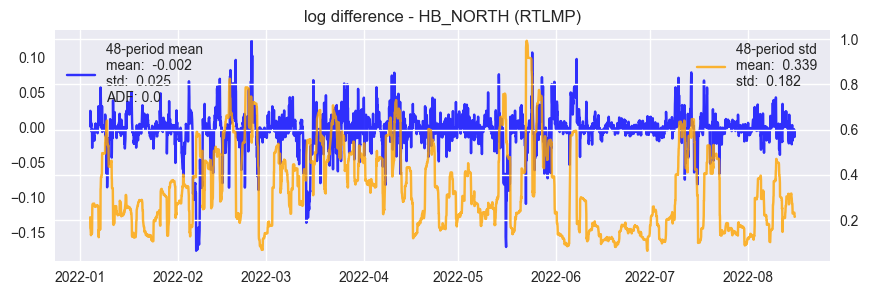

In [58]:
for target_ in target_series.keys():
    for title_, x_ in transforms_targets_series.items():
        ax = plot_rolling_stats(x_[target_])
        plt.title(f'{title_} - {target_}')
        plt.show()

### Observations:
1. It can be seen for both target time series that stationarity (mean and standard deviation of rolling windows near zero and ADF is near zero) is only achieved after calculating first differences of the log transformed time series.
2. The Augmented Dickey Fuller (ADF) test can indicate stationarity.  Notice that the ADF for the time-series actually increases after log transformation and then decreases.   

## Make all Time-Series Features Stationary
SARIMAX and/or other models that accept exogenous (independent) variables require or benefit from time-series inputs that are stationary.  Establish a process and criteria that generates stationary time series for all features.

### Select Target Time Series "X"
Select a single time series to be used as the target variable of models.  This will be the only input data for models that do not use exogenouse variables.

In [61]:
target_feature = cols_target[0]
# target_feature = 'ERCOT (SOLAR_STPPF_BIDCLOSE)'
target_feature_type = df_features.loc[df_features.index == target_feature,
                                      'Feature Type'].item()
cmap_feature = truncate_colormap(feature_cmap[target_feature_type], minval=0.4)
print(f'"{target_feature}" is the target variable of the remainder of this analysis')
print(f'"{target_feature}" is a "{target_feature_type}" type feature')

"HB_NORTH (DALMP)" is the target variable of the remainder of this analysis
"HB_NORTH (DALMP)" is a "DayAhead Price" type feature


In [62]:
X = df[target_feature].copy()
# verify X is a series and has hourly frequency
assert type(X) == pd.core.series.Series
assert X.index.freqstr == 'H'
assert X.notnull().any()
X.head(3)

DATETIME
2022-01-02 06:00:00+00:00    23.79
2022-01-02 07:00:00+00:00    26.63
2022-01-02 08:00:00+00:00    24.79
Freq: H, Name: HB_NORTH (DALMP), dtype: float64

In [63]:
X.describe()

count    5448.000000
mean       67.132527
std        89.782586
min         2.370000
25%        33.062500
50%        49.165000
75%        70.000000
max      2100.110000
Name: HB_NORTH (DALMP), dtype: float64

### Log Transformation

In [64]:
# calculate log transformation and clip any infinite values from transformation
X_log = np.log(X)
X_log = clip_inf_values_to_quantile(X_log)
X_log[:3]

DATETIME
2022-01-02 06:00:00+00:00    3.169265
2022-01-02 07:00:00+00:00    3.282038
2022-01-02 08:00:00+00:00    3.210440
Freq: H, Name: HB_NORTH (DALMP), dtype: float64

### Differencing

In [65]:
X_log_diff = X_log.diff()
X_log_diff = clip_inf_values_to_quantile(X_log_diff)

#### Organize Differenced Series and Assign Colors

In [66]:
X_series = [X, X_log, X_log_diff] 
X_names = ["X", "X_log", "X_log_diff"]
X_dict = dict(zip(X_names, X_series))
X_dict_colors = dict(zip(X_names, colors_from_colormap(len(X_series), cmap_feature)))

### Determine Periodicity
Some models used here will benefit from explicit seasonality/periodical input information.  Additionally, knowing periodicity will help select properly select 'splits' of continuous time series data that captures one or more complete cycles.
It is expected that hourly energy pricing has a repetitive 24-hour cycle that is driven by human consumption patterns.  Energy prices are driven by more complex supply and demand dynamics.  

In [105]:
periods = {'D': 24,
          'W': 24*7,
          'M': 24*7*30,
          'Q': 24*np.ceil(365/4)}

# how often are readings taken in terms of Hz?
sampling_freq_hz =  1 / pd.Timedelta(df.index.freq).seconds
sampling_freq_hz

0.0002777777777777778

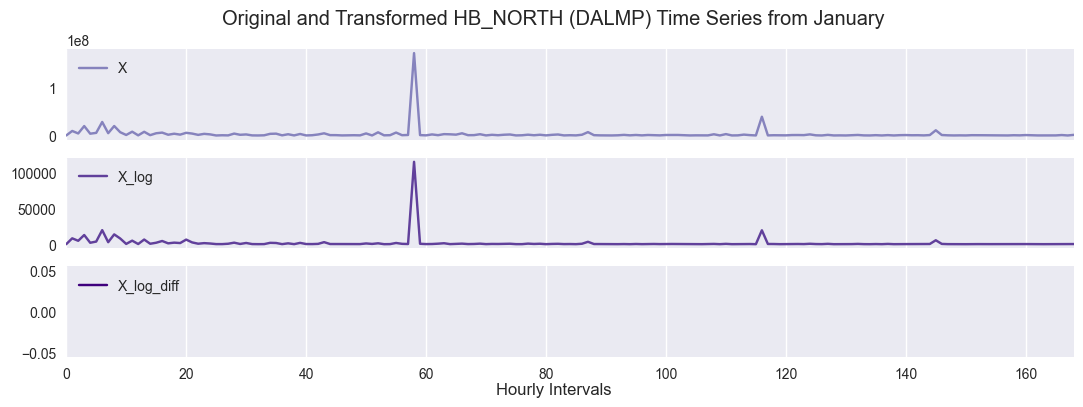

In [94]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(13,4))
for ax_, x_name in zip(ax.flatten(), X_names):
    month_ = X.first('M').index.month_name().unique().item()
    ax_.plot(periodogram(X_dict[x_name].first('M'), fs=sampling_freq_hz)[1],
             color = X_dict_colors[x_name], label=x_name)
#     ax_.set_title(f'{x_name}')
    ax_.set_xlim(0, periods['W'])
    ax_.legend(loc='upper left')
    ax_.grid(axis='y')
fig.suptitle(f'Original and Transformed {target_feature} Time Series from {month_}')
fig.supxlabel('Hourly Intervals')
plt.show()

#### Identify Frequencies with Highest Power Spectral Density
These peaks indicate intervals or frequency of cyclic values

In [69]:
df_period = pd.DataFrame(
            index= np.round(sampling_freq_hz / periodogram(X_dict[x_name].dropna(),
                               fs=sampling_freq_hz)[0], 0),
             data = {'Power spectral density': periodogram(X_dict[x_name].dropna(),
                                           fs=sampling_freq_hz)[1]}).rename_axis('Hours')
df_period.head(3)

C:\Users\user\AppData\Local\Temp\ipykernel_17532\1847530542.py:2: RuntimeWarning: divide by zero encountered in divide
  index= np.round(sampling_freq / periodogram(X_dict[x_name].dropna(),


,Power spectral density
Hours,
inf,3.766894e-29
5447.0,2.145255e-01
2724.0,7.691100e-01


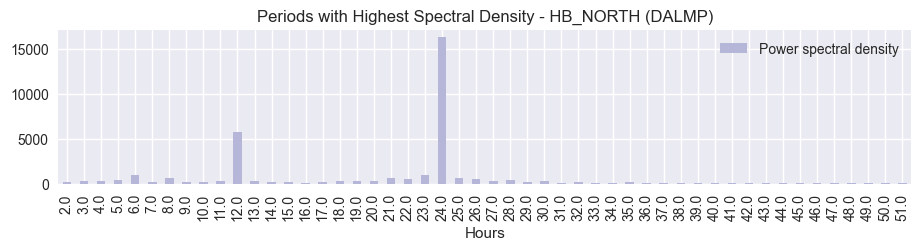

In [106]:
df_period.groupby(level=0).mean().iloc[:50].plot.bar(figsize=(11,2),
        title=f'Periods with Highest Spectral Density - {target_feature}', color=colors_target[target_feature])
plt.show()

In [72]:
periodicity_hourly(X_dict[x_name].dropna())

C:\Users\user\AppData\Local\Temp\ipykernel_17532\361782429.py:10: RuntimeWarning: divide by zero encountered in divide
  index= np.round(sampling_freq / periodogram(x.dropna(),


[24.0, 12.0, 6.0]

In [73]:
def stationator(x, adf_max = 0.0001, rolling_mean_tol = 0.03, rolling_std_tol = 0.3):
    """Returns statistically Stationary version of series 'x'.  Refinements are needed
    with this function.  Proceed with caution"""
    idx_original = x.index.copy()
    x = x.dropna()
#     identify strongest cyclical period that is no more than half the length of x
    period = int([p_ for p_ in periodicity_hourly(x, n=20) if p_ <= 0.51*x.shape[0]][0])
    # calculate log transformation and clip any infinite values from transformation
    X_log = np.log(x)
#     are more than half of all values NaN?  This can happen with a pre-dominately negative time-series
    if X_log.isna().sum() > x.shape[0] * 0.5:
#         FUTURE:  FIx this 4-24-23.  give up.  Return original series
        return x
    else:
    #     are inf or NaN present?  if so, clip:
        if any([x in X_log.describe().values for x in [-np.inf, np.inf, np.NaN]]):
            X_log = clip_inf_values_to_quantile(X_log, q_min=0.01, q_max=0.99)
    #     assume seasonal differencing is needed
        X_log_diff_seasonal = X_log.diff(period)
    #     are inf or NaN present?  if so, clip:
        if any([x in X_log_diff.describe().values for x in [-np.inf, np.inf, np.NaN]]):
            X_log_diff_seasonal = clip_inf_values_to_quantile(X_log_diff_seasonal, q_min=0.01, q_max=0.99 )
    #     does series meet stationary criteria?
        adf_ = tsa.adfuller(X_log_diff_seasonal.dropna())[1]
        mean_rolling = X_log_diff_seasonal.rolling(period).mean().mean()
        std_rolling = X_log_diff_seasonal.rolling(period).std().mean()
    #     print(adf_, mean_rolling, std_rolling)
        if ((np.abs(adf_) < adf_max) & (np.abs(mean_rolling) < rolling_mean_tol) &
            (np.abs(std_rolling) < rolling_std_tol)):
            return X_log_diff_seasonal.reindex(idx_original).interpolate()
    #         print('Stationary')
    # do second difference if first difference of log did not achieve stationarity
        else:
    #         print('Not Stationary')
    # forgo further stationarity tests and return transformed series, interpolate NaN if needed
            X_log_diff2 = X_log_diff_seasonal.diff()
            return X_log_diff2.interpolate()


#### Before applying Stationator

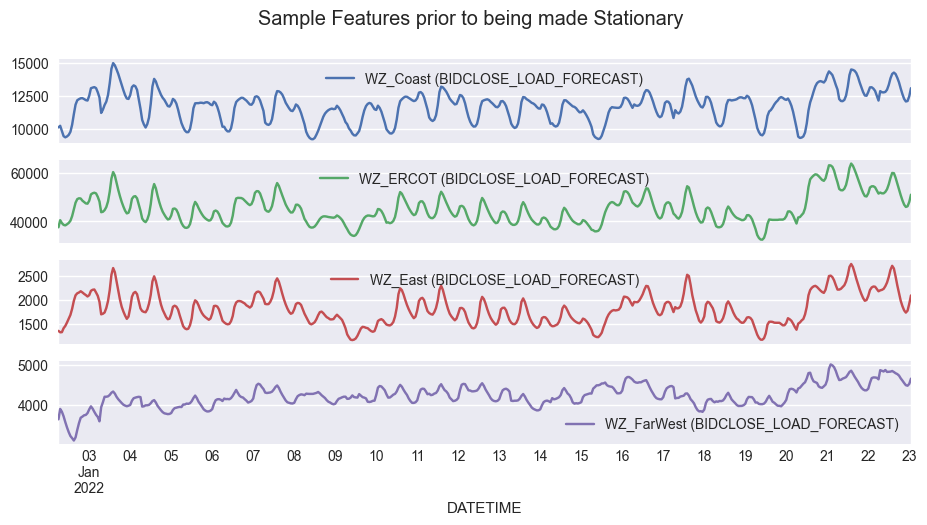

In [74]:
df.iloc[:, :4].iloc[:500].plot(subplots=True,
     title = 'Sample Features prior to being made Stationary')
plt.show()

In [75]:
df.dropna().shape

(5414, 20)

#### After Applying Stationator
To make features meet stationarity criteria

C:\Users\user\AppData\Local\Temp\ipykernel_17532\361782429.py:10: RuntimeWarning: divide by zero encountered in divide
  index= np.round(sampling_freq / periodogram(x.dropna(),
C:\Users\user\AppData\Local\Temp\ipykernel_17532\361782429.py:10: RuntimeWarning: divide by zero encountered in divide
  index= np.round(sampling_freq / periodogram(x.dropna(),
C:\Users\user\AppData\Local\Temp\ipykernel_17532\361782429.py:10: RuntimeWarning: divide by zero encountered in divide
  index= np.round(sampling_freq / periodogram(x.dropna(),
C:\Users\user\AppData\Local\Temp\ipykernel_17532\361782429.py:10: RuntimeWarning: divide by zero encountered in divide
  index= np.round(sampling_freq / periodogram(x.dropna(),


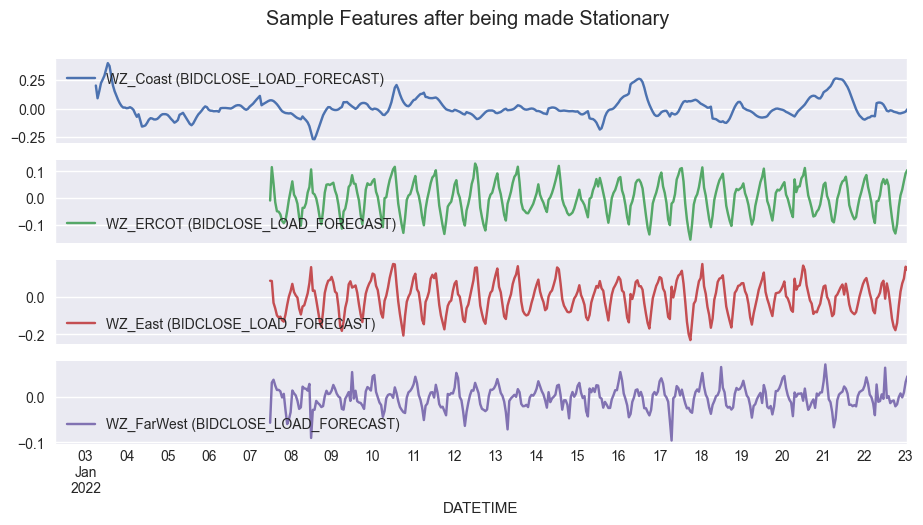

In [76]:
df.iloc[:, :4].iloc[:500].apply(stationator, axis=0).plot(subplots=True,
     title = 'Sample Features after being made Stationary')
plt.show()

### Make all significant features stationary

In [83]:
df_stationary = df.apply(stationator, axis=0)
# confirm no series were lost
assert df_stationary.shape == df.shape
# Remove records where all values are NaN
df_stationary.dropna(how='all', axis=0, inplace=True)
# assert df_stationary.notnull().all().all()
display(df_stationary.shape)
df_stationary.describe()

(5472, 20)

,WZ_Coast (BIDCLOSE_LOAD_FORECAST),WZ_ERCOT (BIDCLOSE_LOAD_FORECAST),WZ_East (BIDCLOSE_LOAD_FORECAST),WZ_FarWest (BIDCLOSE_LOAD_FORECAST),WZ_North (BIDCLOSE_LOAD_FORECAST),WZ_NorthCentral (BIDCLOSE_LOAD_FORECAST),WZ_SouthCentral (BIDCLOSE_LOAD_FORECAST),WZ_Southern (BIDCLOSE_LOAD_FORECAST),WZ_West (BIDCLOSE_LOAD_FORECAST),ERCOT (TOTAL_RESOURCE_CAP_OUT),ERCOT (SOLAR_STPPF_BIDCLOSE),ERCOT (WIND_STWPF_BIDCLOSE),GR_COASTAL (WIND_STWPF_BIDCLOSE),GR_ERCOT (WIND_STWPF_BIDCLOSE),GR_NORTH (WIND_STWPF_BIDCLOSE),GR_PANHANDLE (WIND_STWPF_BIDCLOSE),GR_SOUTH (WIND_STWPF_BIDCLOSE),GR_WEST (WIND_STWPF_BIDCLOSE),HB_NORTH (DALMP),HB_NORTH (RTLMP)
count,5472.000000,5472.000000,5472.000000,2747.000000,5472.000000,5472.000000,5472.000000,5472.000000,5472.000000,2747.000000,5472.000000,5471.000000,5471.000000,5471.000000,5471.000000,5471.000000,5471.000000,5471.000000,5472.000000,5389.000000
mean,0.001593,0.001108,0.000635,0.000006,0.000547,0.000475,0.001690,0.001819,-0.000410,-0.000994,0.005536,0.000108,-0.000030,0.000108,0.000315,0.000026,0.000309,0.000106,0.006413,0.003297
std,0.065295,0.078265,0.116673,0.020949,0.157689,0.122998,0.112959,0.089617,0.114263,0.049250,0.231269,0.117977,0.233427,0.117977,0.246033,0.249822,0.163791,0.193749,0.420764,0.411704
min,-0.304784,-0.335434,-0.393617,-0.116545,-0.832896,-0.447880,-0.519104,-0.377086,-0.417851,-0.372173,-2.176249,-0.798494,-1.806988,-0.798494,-5.404134,-1.281392,-1.169083,-1.675542,-2.651852,-2.394150
25%,-0.033480,-0.039023,-0.064077,-0.013041,-0.067908,-0.060748,-0.052592,-0.035926,-0.060521,-0.006264,-0.013911,-0.059408,-0.093910,-0.059408,-0.093759,-0.117530,-0.067008,-0.089796,-0.163154,-0.130057
50%,-0.000949,-0.002022,-0.003152,-0.001734,-0.004157,-0.005342,-0.001438,0.002030,-0.006607,0.000000,0.000000,-0.004709,-0.007679,-0.004709,-0.005678,-0.005188,-0.004534,-0.002472,-0.002302,0.000263
75%,0.032062,0.028764,0.049229,0.010745,0.062463,0.047674,0.038412,0.037889,0.049277,0.007411,0.016436,0.052481,0.085350,0.052481,0.083180,0.106094,0.058608,0.080455,0.156646,0.134044
max,0.399167,0.380940,0.614193,0.161737,1.042654,0.653417,0.621393,0.655246,0.588441,0.369323,1.993397,1.001956,1.809588,1.001956,3.823953,1.513055,1.242128,2.792970,2.047613,2.854966


### Inspect Causality
Now that features are stationary, the Grainger Causality test can be performed.

Any particular lagged value of one of the variables is retained in the regression if:
1. it is significant according to a t-test, and 
2. it and the other lagged values of the variable jointly add explanatory power to the model according to an F-test

Then the null hypothesis of no Granger causality is not rejected if and only if no lagged values of an explanatory variable have been retained in the regression
https://en.wikipedia.org/wiki/Granger_causality#Method

If the p-value is less than "p_max_grainger", we can reject the null hypothesis of the test and conclude that knowing feature_2 (second feature in test input) is useful for predicting the value of feature_1.

In [84]:
p_max_grainger = 0.05

In [85]:
lag_ = 12
ans = grangercausalitytests(df_stationary[[cols_target[0], df_stationary.columns[0]]].dropna(), maxlag=[lag_])
p_ = round(ans[lag_][0]['ssr_ftest'][1],3)
if p_ < p_max_grainger:
    print(f'{df_stationary.columns[0]} Has a {p_} P-value which is less than {p_max_grainger} and has meaningful predictive value')
else:
    print(f'{df_stationary.columns[0]} Has a {p_} P-value which is greater than {p_max_grainger} and does not have meaningful predictive value')


Granger Causality
number of lags (no zero) 12
ssr based F test:         F=5.3804  , p=0.0000  , df_denom=5435, df_num=12
ssr based chi2 test:   chi2=64.8624 , p=0.0000  , df=12
likelihood ratio test: chi2=64.4801 , p=0.0000  , df=12
parameter F test:         F=5.3804  , p=0.0000  , df_denom=5435, df_num=12
WZ_Coast (BIDCLOSE_LOAD_FORECAST) Has a 0.0 P-value which is less than 0.05 and has meaningful predictive value


In [86]:
def grainger_causality_p(df, max_lag=12):
    """Returns p-score of Grainger Causality 'ssr_ftest' from input df
    containing 'df[target, feature_to_test]'"""
    ans = grangercausalitytests(df, maxlag=max_lag, verbose=False)
    return round(ans[lag_][0]['ssr_ftest'][1],3)

In [87]:
feature_causality = dict.fromkeys(cols_target)

for target_ in cols_target:
    feature_causality[target_] = {}
    for feature_ in df_stationary.columns.difference(cols_target):
        print(target_, feature_)
        feature_causality[target_][feature_] = grainger_causality_p(
                    df[[target_, feature_]].dropna())

HB_NORTH (DALMP) ERCOT (SOLAR_STPPF_BIDCLOSE)
HB_NORTH (DALMP) ERCOT (TOTAL_RESOURCE_CAP_OUT)
HB_NORTH (DALMP) ERCOT (WIND_STWPF_BIDCLOSE)
HB_NORTH (DALMP) GR_COASTAL (WIND_STWPF_BIDCLOSE)
HB_NORTH (DALMP) GR_ERCOT (WIND_STWPF_BIDCLOSE)
HB_NORTH (DALMP) GR_NORTH (WIND_STWPF_BIDCLOSE)
HB_NORTH (DALMP) GR_PANHANDLE (WIND_STWPF_BIDCLOSE)
HB_NORTH (DALMP) GR_SOUTH (WIND_STWPF_BIDCLOSE)
HB_NORTH (DALMP) GR_WEST (WIND_STWPF_BIDCLOSE)
HB_NORTH (DALMP) WZ_Coast (BIDCLOSE_LOAD_FORECAST)
HB_NORTH (DALMP) WZ_ERCOT (BIDCLOSE_LOAD_FORECAST)
HB_NORTH (DALMP) WZ_East (BIDCLOSE_LOAD_FORECAST)
HB_NORTH (DALMP) WZ_FarWest (BIDCLOSE_LOAD_FORECAST)
HB_NORTH (DALMP) WZ_North (BIDCLOSE_LOAD_FORECAST)
HB_NORTH (DALMP) WZ_NorthCentral (BIDCLOSE_LOAD_FORECAST)
HB_NORTH (DALMP) WZ_SouthCentral (BIDCLOSE_LOAD_FORECAST)
HB_NORTH (DALMP) WZ_Southern (BIDCLOSE_LOAD_FORECAST)
HB_NORTH (DALMP) WZ_West (BIDCLOSE_LOAD_FORECAST)
HB_NORTH (RTLMP) ERCOT (SOLAR_STPPF_BIDCLOSE)
HB_NORTH (RTLMP) ERCOT (TOTAL_RESOURCE_CAP_OUT

#### Save Causality test results to df_causality
True values indicate feature satisfies p-value for a given feature.  Use these results to filter features to consider for time-series models.

In [88]:
df_causality_p = pd.DataFrame.from_dict(feature_causality)
df_causality_p = df_causality_p.lt(p_max_grainger)
df_causality_p

,HB_NORTH (DALMP),HB_NORTH (RTLMP)
ERCOT (SOLAR_STPPF_BIDCLOSE),True,True
ERCOT (TOTAL_RESOURCE_CAP_OUT),True,False
ERCOT (WIND_STWPF_BIDCLOSE),True,True
GR_COASTAL (WIND_STWPF_BIDCLOSE),True,True
GR_ERCOT (WIND_STWPF_BIDCLOSE),True,True
GR_NORTH (WIND_STWPF_BIDCLOSE),True,True
GR_PANHANDLE (WIND_STWPF_BIDCLOSE),True,True
GR_SOUTH (WIND_STWPF_BIDCLOSE),True,True
GR_WEST (WIND_STWPF_BIDCLOSE),True,True
WZ_Coast (BIDCLOSE_LOAD_FORECAST),True,True


#### Save df_causality_p to disk

In [89]:
file_causality = data_dir / 'feature_causality.csv'
print(file_causality)
df_causality_p.to_csv(file_causality)
assert file_causality.is_file()

C:\Users\user\OneDrive\python_envs\ERCOT_electricity_price_forecast\data\feature_causality.csv


#### Save df_stationary test to disk

In [90]:
file_ts_stationary = data_dir / 'ts_select_stationary.csv'
print(file_ts_stationary)
df_stationary.to_csv(file_ts_stationary)
assert file_ts_stationary.is_file()

C:\Users\user\OneDrive\python_envs\ERCOT_electricity_price_forecast\data\ts_select_stationary.csv


# END

Proceed to "4 - ARIMA Time Series Models"